In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

(771, 1028)


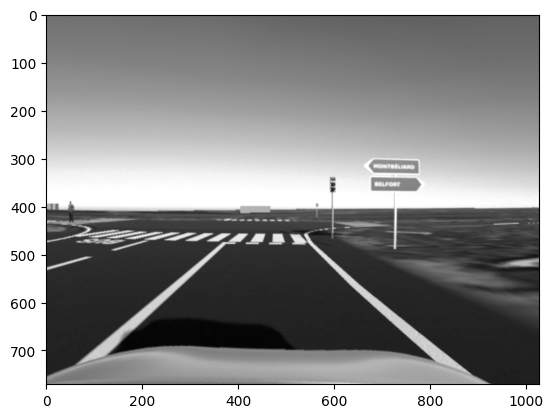

In [2]:
img = cv2.imread('image.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

print(img.shape)

plt.imshow(img, cmap='gray')

Calibration matrices

In [3]:
K = np.array([  [1124.66943359375, 0.0, 505.781982421875],
                [0.0, 1124.6165771484375, 387.8110046386719],
                [0.0, 0.0, 1.0]])

T_cam_to_ground = np.array([[ 0.99991969 , 0.01149682 ,-0.00533206 , 0.05419943],
 [ 0.00510958 , 0.01929436 , 0.99980079 , 1.96159697],
 [ 0.0115974  ,-0.99974774  ,0.01923406  ,1.55057154],
    [ 0.          ,0.          ,0.          ,1.        ]])


print(K)
print(T_cam_to_ground)

[[1.12466943e+03 0.00000000e+00 5.05781982e+02]
 [0.00000000e+00 1.12461658e+03 3.87811005e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
[[ 0.99991969  0.01149682 -0.00533206  0.05419943]
 [ 0.00510958  0.01929436  0.99980079  1.96159697]
 [ 0.0115974  -0.99974774  0.01923406  1.55057154]
 [ 0.          0.          0.          1.        ]]


In [4]:
pts_ground = np.array([[0., 0., 0., 1.],
                       [1., 0., 0., 1.],
                       [0., 1., 0., 1.],
                       [1., 1., 0., 1.]])

# put sqare in front of camera
pts_ground += np.array([-0.5, 8., 0., 0.])

pts_ground = pts_ground.T


print(pts_ground)

[[-0.5  0.5 -0.5  0.5]
 [ 8.   8.   9.   9. ]
 [ 0.   0.   0.   0. ]
 [ 1.   1.   1.   1. ]]


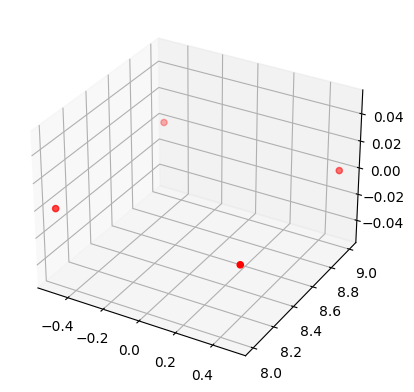

In [5]:
# plot in 3D
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pts_ground[0,:], pts_ground[1,:], pts_ground[2,:], c='r', marker='o')


In [6]:
pts_cam = np.linalg.inv(T_cam_to_ground) @ pts_ground
print(pts_cam)

[[-0.54128381  0.45863589 -0.53617422  0.46374547]
 [ 1.66031596  1.67181277  1.67961031  1.69110713]
 [ 6.01033135  6.00499929  7.01013214  7.00480008]
 [ 1.          1.          1.          1.        ]]


[1.66031596 1.67181277 1.67961031 1.69110713]


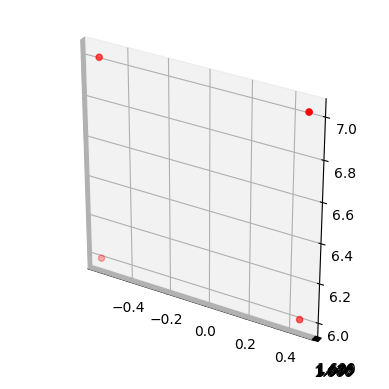

In [7]:
print(pts_cam[1,:])
# plot in 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(pts_cam[0,:], pts_cam[1,:], pts_cam[2,:], c='r', marker='o')

ax.set_box_aspect([ub - lb for lb, ub in (getattr(ax, f'get_{a}lim')() for a in 'xyz')])

Projection

In [8]:
pts_sensor = pts_cam[:2] / pts_cam[2]
pts_sensor = np.vstack((pts_sensor, np.ones((1,4))))
print(pts_sensor)

[[-0.0900589   0.07637568 -0.07648561  0.06620396]
 [ 0.27624367  0.27840349  0.23959753  0.24142118]
 [ 1.          1.          1.          1.        ]]


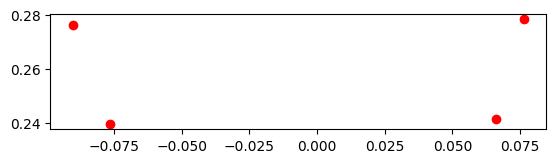

In [9]:
# plot in 2D
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(pts_sensor[0,:], pts_sensor[1,:], c='r', marker='o')
ax.set_aspect('equal')

capeur -> image

In [10]:
pts_img = K @ pts_cam[:3]
pts_img = pts_img / pts_img[2]
print(pts_img)

[[404.49549465 591.67937233 419.76095639 580.23954765]
 [698.47920982 700.90818683 657.26635368 659.3172696 ]
 [  1.           1.           1.           1.        ]]


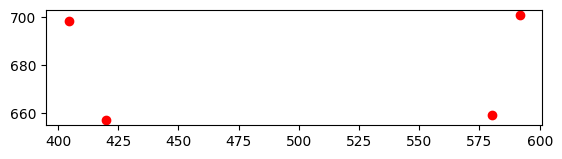

In [11]:
# plot in 2D
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(pts_img[0,:], pts_img[1,:], c='r', marker='o')
ax.set_aspect('equal')

Calculer l'homographie

In [27]:
scale = 20
offset_hori = min(pts_ground[0,:])
print(offset_hori)

pts_ground_viz = pts_ground[:2].copy()
pts_ground_viz *= scale
pts_ground_viz = pts_ground_viz.T.astype(np.float32)

print(pts_img[:2].T.astype(np.float32))
print(pts_ground_viz)

# permet que l'image ne soit pas positionnée par rapport au carré, qui lui est exprimé par rapport au coin à gauche de l'image
user_offset = np.array([500., 0.])
pts_ground_viz += user_offset
print(pts_ground_viz)

H = cv2.getPerspectiveTransform(pts_img[:2].T.astype(np.float32), pts_ground_viz)
print(H)

-0.5
[[404.49548 698.4792 ]
 [591.6794  700.9082 ]
 [419.76096 657.26636]
 [580.23956 659.31726]]
[[-10. 160.]
 [ 10. 160.]
 [-10. 180.]
 [ 10. 180.]]
[[490. 160.]
 [510. 160.]
 [490. 180.]
 [510. 180.]]
[[-6.24443851e-02 -1.24244584e+00  5.40754818e+02]
 [ 7.34703323e-04 -9.87028653e-02 -4.64005766e+01]
 [ 2.87394074e-05 -2.47775170e-03  1.00000000e+00]]


Projeter image

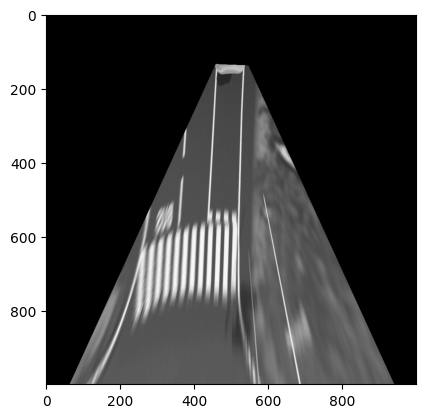

In [29]:
img_warped = cv2.warpPerspective(img, H, (1000, 1000))
plt.imshow(img_warped, cmap='gray')